In [1]:
import sys
src_dir = '/Users/palmerio/Science_projects/GRB_population_model/src/'
sys.path.insert(0, src_dir)
verbose = True
run_mode = 'debug'

# GRB pop module imports
import prototype_GRB_population as pt
from GRB_population import GRBPopulation
import physics as ph
import stats as st
import io_grb_pop as io
import miscelaneous as msc
import plotting_functions as pf
from cosmology import init_cosmology
from ECLAIRs import init_ECLAIRs
import observational_constraints as obs

# General imports
import yaml
import logging
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

# specific imports
from scipy.stats import ks_2samp
from scipy.stats import mstats
from itertools import product

log = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG,
                    format='%(asctime)s.%(msecs)03d [%(levelname)s] %(message)s',
                    datefmt='%H:%M:%S')

plt.style.use('presentation')

############
load_files = True
############

In [28]:
paths_to_dir, paths_to_files = io.generate_paths()
config, params, instruments, samples = io.read_init_files(paths_to_files)
io.create_output_dir(paths_to_dir, dir_name=config['output_dir'],
                             run_mode=run_mode)
if load_files:
    df_LN = pd.read_csv(paths_to_dir['root']/'model_outputs/Zeljka_w_Cvar/lognormal_Ep.dat',sep='\t',low_memory=False)    
    df_A = pd.read_csv(paths_to_dir['root']/'model_outputs/Zeljka_w_Cvar/Intrinsic_correlation.dat',sep='\t',low_memory=False)    
    
else:
    np.random.seed(0)
    tstart = time.time()
    GRB_population = GRBPopulation(Nb_GRBs, output_dir=paths_to_dir['output'])
    GRB_prop = GRB_population.draw_GRB_properties(cosmo=cosmo, params=params)

    ph.calc_peak_photon_flux(GRB_prop, incl_instruments, ECLAIRs_prop)
    ph.calc_peak_energy_flux(GRB_prop, incl_instruments, ECLAIRs_prop)
    ph.calc_photon_fluence(GRB_prop, incl_instruments)
    ph.calc_energy_fluence(GRB_prop, incl_instruments)
    ph.calc_det_prob(GRB_prop, incl_samples, **ECLAIRs_prop)

    df = pd.DataFrame(GRB_prop)

11:35:05.533 [DEBUG] Root directory is /Users/palmerio/Science_projects/GRB_population_model
11:35:05.533 [DEBUG] Directory paths :
    'root'    : /Users/palmerio/Science_projects/GRB_population_model
    'obs'     : /Users/palmerio/Science_projects/GRB_population_model/observational_constraints
    'init'    : /Users/palmerio/Science_projects/GRB_population_model/init
    'output'  : /Users/palmerio/Science_projects/GRB_population_model/model_outputs
    'data'    : /Users/palmerio/Science_projects/GRB_population_model/data
    'cosmo'   : /Users/palmerio/Science_projects/GRB_population_model/data/cosmology
    'ECLAIRs' : /Users/palmerio/Science_projects/GRB_population_model/data/ECLAIRs
11:35:05.534 [DEBUG] File paths :
    'config'  : /Users/palmerio/Science_projects/GRB_population_model/init/config.yml
    'param'   : /Users/palmerio/Science_projects/GRB_population_model/init/parameters.yml
    'instrum' : /Users/palmerio/Science_projects/GRB_population_model/init/instruments.yml

In [53]:
df_A.dropna(inplace=True)
df_A.rename(columns={'# z':'z'}, inplace=True, errors="raise")
df_A

,z,alpha,beta,Epobs,L,Eiso,t90,Cvar,pht_pflx_BATSE,erg_pflx_BATSE,pht_flnc_BATSE,erg_flnc_BATSE,pht_pflx_BAT,erg_pflx_BAT,pht_flnc_BAT,erg_flnc_BAT,pht_pflx_GBM,erg_pflx_GBM,pht_flnc_GBM,erg_flnc_GBM
1,3.158,1.160800,3.07715,86.070571,5.361516e+50,1.487931e+51,18.163956,0.152786,0.016763,2.673684e-09,0.193436,3.085245e-08,0.047450,3.350649e-09,0.547540,3.866416e-08,0.065450,4.953026e-09,0.755247,5.715447e-08
2,4.165,-0.237003,2.18647,24.974238,1.073257e+52,2.232231e+52,4.868448,0.427214,0.077896,1.280371e-08,0.836802,1.375440e-07,0.321207,1.903363e-08,3.450571,2.044690e-07,0.466624,3.243350e-08,5.012711,3.484172e-07
3,3.432,0.433020,2.89143,15.454588,4.793684e+50,3.183989e+50,1.894917,0.350519,0.004569,6.408886e-10,0.013450,1.886620e-09,0.042886,1.977980e-09,0.126247,5.822691e-09,0.076017,2.861329e-09,0.223775,8.423058e-09
4,3.139,0.705592,2.49261,6.366741,1.283336e+50,3.340793e+50,14.781223,0.176116,0.001211,1.850942e-10,0.013049,1.994332e-09,0.007595,3.875432e-10,0.081833,4.175658e-09,0.014375,6.257501e-10,0.154890,6.742263e-09
5,2.637,0.587377,4.04809,9.885951,4.850645e+50,1.979007e+51,17.017905,0.239741,0.001518,1.771029e-10,0.022528,2.627948e-09,0.053195,1.944563e-09,0.789341,2.885448e-08,0.125097,3.356210e-09,1.856250,4.980126e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99996,4.251,0.497795,2.51747,68.760192,3.136332e+50,9.940702e+50,38.243454,0.082878,0.004518,7.095453e-10,0.075187,1.180911e-08,0.012069,8.748517e-10,0.200870,1.456034e-08,0.015665,1.364831e-09,0.260723,2.271517e-08
99997,2.971,0.394991,3.07715,87.191057,2.210244e+50,3.757862e+50,3.936629,0.431893,0.010198,1.594455e-09,0.068850,1.076497e-08,0.023257,1.846072e-09,0.157023,1.246376e-08,0.029026,2.628497e-09,0.195969,1.774631e-08
99998,5.094,0.770485,2.25587,353.914339,2.099430e+50,5.506239e+49,1.484169,0.176714,0.000708,1.486809e-10,0.001132,2.376355e-10,0.000963,9.134600e-11,0.001539,1.459976e-10,0.001530,3.227140e-10,0.002445,5.157913e-10
99999,3.168,0.482071,2.61339,51.142406,2.190466e+50,1.818115e+50,6.196220,0.133955,0.006244,9.373423e-10,0.021600,3.242730e-09,0.021384,1.398371e-09,0.073978,4.837656e-09,0.028257,2.012262e-09,0.097754,6.961407e-09


In [7]:
col_to_write = ['z', 'alpha', 'beta', 'Epobs', 'L', 'Eiso', 't90', 'Cvar',
                'pht_pflx_BATSE','erg_pflx_BATSE','pht_flnc_BATSE','erg_flnc_BATSE',
                'pht_pflx_BAT','erg_pflx_BAT','pht_flnc_BAT','erg_flnc_BAT',
                'pht_pflx_GBM','erg_pflx_GBM','pht_flnc_GBM','erg_flnc_GBM']

if not load_files:
    df.to_csv(paths_to_dir['output']/'lognormal_Ep.dat',sep='\t', index=False, columns=col_to_write)

In [13]:
def plot_obs_property(fname, key, func=None,  ax=None, log=False, kde=True, header=2, verbose=False, debug=False, **kwargs):
    """
        Convenience function to quickly plot an observed sample from a given file name.
        A function to filter or cut the sample can be passed as func.
    """
    # Read the entire file
    df_obs = pd.read_csv(fname, sep='|', header=header, low_memory=False)
    # Strip the colum names to remove whitespaces
    df_obs.rename(columns=lambda x:x.strip(), inplace=True)
    # Activate verbose to check the column names
    if debug:
        for i,col in enumerate(df_obs.columns):
            print(i,col)
    if func is None:
        df_prop = pd.to_numeric(df_obs[key], errors='coerce')
    else:
        df_prop = func(df_obs, key)

    if log:
        df_prop = np.log10(df_prop)
    if verbose:
        print("Sample size :{}".format(len(df_prop)))
    if ax is None:
        ax = plt.gca()
        
    ax.hist(df_prop, **kwargs)
    if kde:
        sns.kdeplot(df_prop, ax=ax, color='k', linewidth=2, label='KDE')
    return

def filter_EpGBM_obs(df, key, pflx_min=0.9):
    """
        Filter the sample following the criteria for the EpGBM sample:
            - Complete; i.e. pflx [50-300 keV] > 0.9 ph/cm2/s
            - Long; i.e. T90 > 2s
    """
    for k in ['pflx_band_phtfluxb', 't90', key]:
        df[k] = pd.to_numeric(df[k], errors='coerce')
    t90_condition = (df['t90'] >= 2)
    pflx_condition = (df['pflx_band_phtfluxb'] >= pflx_min)
    final_mask = t90_condition & pflx_condition
    df_out = df[final_mask][key].copy()
    return df_out

Sample size :1313


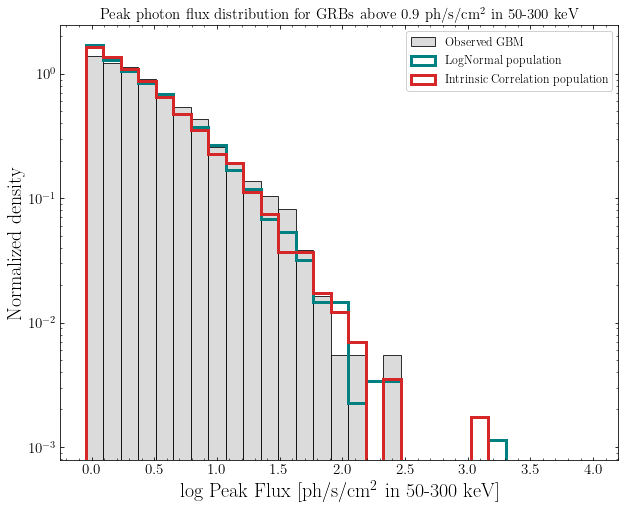

In [56]:
## Observational data
fname = '../catalog/GBM_cat/fermi_GBM_cat_total.dat'
fig, ax = plt.subplots(figsize=(10,8))
bins = np.linspace(np.log10(0.9), 4, 30)
plot_obs_property('../catalogs/GBM_cat/fermi_GBM_cat_total.dat',
                  key='pflx_band_phtfluxb',
                  func=filter_EpGBM_obs,
                  log=True, verbose=True, kde=False,
                  bins=bins,
                  ax=ax, density=True, label='Observed GBM', alpha=0.8,
                  color='lightgray')
cond_LN = df_LN['pht_pflx_BATSE'] >= 0.9
ax.hist(np.log10(df_LN[cond_LN]['pht_pflx_BATSE']), bins=bins, density=True,
        color='teal', histtype='step', linewidth=3, label='LogNormal population')
cond_A = df_A['pht_pflx_BATSE'] >= 0.9
ax.hist(np.log10(df_A[cond_A]['pht_pflx_BATSE']), bins=bins, density=True,
        color='C3', histtype='step', linewidth=3, label='Intrinsic Correlation population')
ax.set_yscale('log')
ax.set_xlabel(r'log Peak Flux [ph/s/cm$^2$ in 50-300 keV]')
ax.set_ylabel('Normalized density')
ax.legend()
ax.set_title('Peak photon flux distribution for GRBs above 0.9 ph/s/cm$^2$ in 50-300 keV', **{'size':15})
plt.show()
